In [1]:
import re
import nltk
import string
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from indoNLP.preprocessing import replace_slang
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
# LOAD DATA

data = pd.read_csv(r'data.csv')

data

,komentar,sentiment
0,"mantab, lebih baik dari aplikasi sebelah.",positif
1,Baik,positif
2,ok banget,positif
3,yaudah oke makasih banyak,positif
4,klo order GO-RIDE sering banget dapat driver y...,negatif
...,...,...
59495,Akhir2 ini make gofud susah banget dapet drive...,negatif
59496,"merasa kurang nyaman, Driver nya bnyak yg Jute...",negatif
59497,"makin lama makin buruk pelayanan nya, pengirim...",negatif
59498,Nomor laporan 83296933 tidak ada kabar lagi. C...,negatif


In [3]:
# CHECK CLASS DISTRIBUTION
data['sentiment'].value_counts()

sentiment
negatif    39311
positif    20189
Name: count, dtype: int64

In [4]:
# CEK KOMENTAR POSITIF DAN NEGATIF

display(data[data['sentiment'] == 'positif']['komentar'][10:21].values)

print()

display(data[data['sentiment'] == 'negatif']['komentar'][5:11].values)

array(['mantapppp', 'biasa pake gofood n gosend sangat membantu..tanx',
       'bagus driver sopan, ngter jemput sudah sesuai titik jemput',
       'bagus', 'bagus', '👍👍👍👍', 'bagus', 'bagus', 'bagus',
       'sangat membantu saat berpergian', 'keren'], dtype=object)

array(['kadang pengiriman salah rumah, untuk kedepannya di perhatikan lagi driver nya',
       'lah gimana ini gojek mau di jual ke grab ,,lemah amat sebagai apk karya anak bangsa',
       'gila gojek ga bgt, better grab',
       'Aplikasi ampas. Pakai go mart barang ga nyampe karna stok kosong TAPI DANA TIDAK DI KEMBALIKAN. LUCU !!!',
       'gojek selalu ngerampok dengan dalih uang saldo kita di alihkan ke gopay tabungan padahal hilang di rampok',
       'gak bisa daftar'], dtype=object)

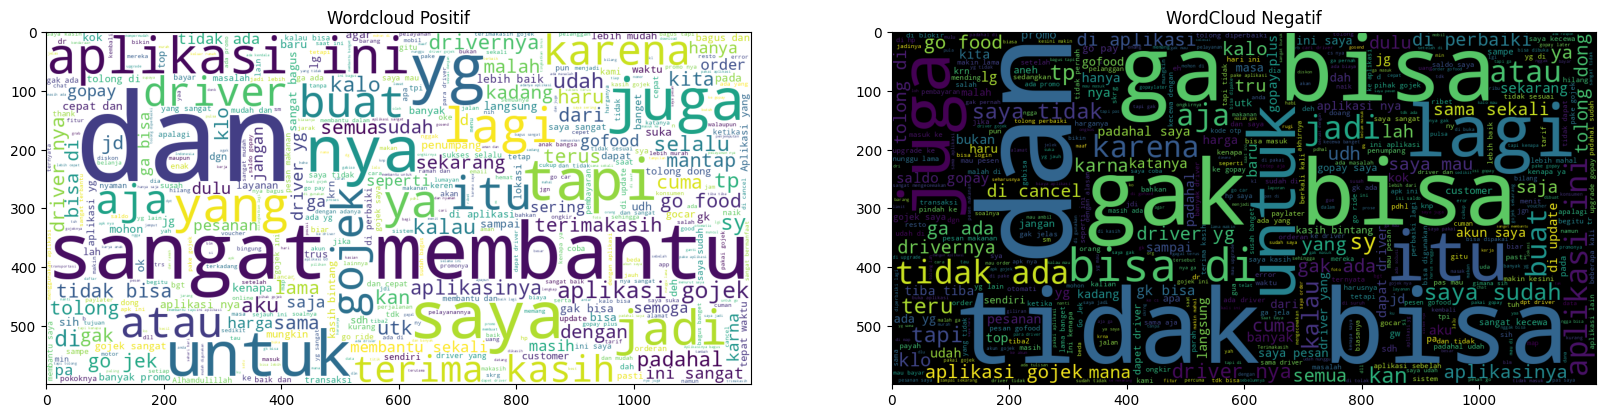

In [5]:
# WORDCLOUD

wordcloud_positif = WordCloud(width = 1200, height = 600, max_words = 500, background_color = 'white').generate(text = ' '.join(data[data['sentiment'] == 'positif']['komentar']))
wordcloud_negatif = WordCloud(width = 1200, height = 600, max_words = 500, background_color = 'black').generate(text = ' '.join(data[data['sentiment'] == 'negatif']['komentar']))

plt.figure(figsize = (20,6))

plt.subplot(1,2,1)
plt.title('Wordcloud Positif')
plt.imshow(wordcloud_positif)

plt.subplot(1,2,2)
plt.title('WordCloud Negatif')
plt.imshow(wordcloud_negatif)

plt.show()

# Feature Extraction

In [3]:
# DEFINE STOPWORDS

stop_words = {
    'aku', 'saya', 'kamu', 'kau', 'dia', 'mereka', 'kita', 'kami', 
    '-ku', '-mu', '-nya', 'kalian', 'engkau', 'hamba', 'beta', 
    'anda', 'beliau', 'dan', 'atau', 'tetapi', 'namun', 'sebab', 
    'karena', 'jika', 'kalau', 'agar', 'supaya', 'meski', 
    'walaupun', 'sementara', 'sedangkan', 'bahwa', 'sehingga', 
    'sejak', 'sampai', 'ketika', 'sebelum', 'sesudah', 'setelah', 
    'sewaktu', 'di', 'ke', 'dari', 'pada', 'dalam', 'dengan', 
    'tanpa', 'atas', 'bawah', 'antara', 'untuk', 'kepada', 'oleh', 
    'terhadap', 'seperti', 'bagi', 'menurut', 'tentang', 'hingga', 
    'melalui', 'sepanjang', 'versus', 'lah', 'kah', 'pun', 'tah', 
    'per', 'para', 'si', 'sang', 'yang', 'itu', 'ini', 'sini', 
    'situ', 'sana', 'anu', 'hal', 'segala', 'suatu', 'seseorang', 
    'sendiri', 'diri', 'pula', 'juga', 'hanya', 'cuma', 'hampir', 
    'lagi', 'lebih', 'kurang', 'tidak', 'bukan', 'jangan', 'belum', 
    'sudah', 'pernah', 'akan', 'telah', 'hendak', 'musti', 'bisa', 
    'dapat', 'boleh', 'harus', 'perlu', 'mau', 'ingin', 'siap', 
    'masih', 'adalah', 'ialah', 'yaitu', 'adanya', 'bagaimana', 
    'apa', 'apakah', 'kenapa', 'mengapa', 'mana', 'kapan', 'berapa', 
    'siapa', 'saja', 'sama', 'ataukah', 'dengankah', 'dikah', 
    'kahkah', 'kekah', 'olehkah', 'punakah', 'ada', 'adanya', 
    'amat', 'bagai', 'bagaimana', 'bagi', 'bahwa', 'bahwasanya', 
    'bahwasannya', 'baru', 'belum', 'bukan', 'buat', 'dahulu', 
    'dalam', 'dan', 'dengan', 'dia', 'diantara', 'dong', 
    'dua', 'dulu', 'empat', 'enggak', 'enggaknya', 'entah', 'gak', 
    'gua', 'guna', 'gunakan', 'hampir', 'harus', 'hingga', 'ia', 
    'ialah', 'ibu', 'ini', 'itu', 'jadi', 'jika', 'kami', 'kamu', 
    'karena', 'ke', 'kemudian', 'kepada', 'kini', 'kira', 'kita', 
    'lain', 'lalu', 'lama', 'lima', 'lu', 'macam', 
    'mahu', 'maka', 'malah', 'mana', 'masa', 'masih', 'masing', 
    'melainkan', 'melalui', 'memang', 'mempunyai', 'mulai', 'nah', 
    'nak', 'nantinya', 'nanti', 'nya', 'oleh', 'pada', 'padahal', 
    'pak', 'para', 'per', 'percuma', 'pula', 'pun', 'rupanya', 
    'saat', 'saja', 'saling', 'sama', 'sambil', 'sampai', 'sana', 
    'saya', 'se', 'sebab', 'sebagai', 'sebagaimana', 'sebaiknya', 
    'sebaliknya', 'sebanyak', 'sebelum', 'sebelumnya', 'sebenarnya', 
    'secara', 'secukupnya', 'sedang', 'sedangkan', 'sedikit', 
    'sedikitnya', 'segala', 'segalanya', 'segera', 'seharusnya', 
    'sehingga', 'sejak', 'sejenak', 'sekadar', 'sekali', 'sekalian', 
    'sekaligus', 'sekalipun', 'sekarang', 'seketika', 'sekiranya', 
    'sekitar', 'sela', 'selain', 'selalu', 'selama', 'seluruh', 
    'seluruhnya', 'semacam', 'semakin', 'semampu', 'semasa', 
    'semasih', 'semata', 'semaunya', 'sementara', 'sempat', 
    'semua', 'semula', 'sendiri', 'sendirian', 'sendirinya', 
    'seolah', 'seorang', 'sepanjang', 'sepantasnya', 
    'sepantasnyalah', 'seperlunya', 'seperti', 'sepertinya', 
    'serupa', 'sesaat', 'sesama', 'sesampai', 'sesegera', 
    'sesekali', 'seseorang', 'sesuatu', 'sesudah', 'sesudahnya', 
    'setelah', 'setempat', 'setengah', 'seterusnya', 'setiap', 
    'setiba', 'setidaknya', 'seusai', 'sewaktu', 'siap', 'siapa', 
    'siapakah', 'sini', 'sinilah', 'suatu', 'sudah', 'sudahkah', 
    'supaya', 'tadi', 'tadinya', 'tak', 'tanpa', 'tanya', 
    'tanyalah', 'tapi', 'tentu', 'tentulah', 'terdahulu', 
    'terhadap', 'tersebut', 'tersebutlah', 'tertentu', 'tiap', 
    'tiba', 'tidak', 'tidakkah', 'toh', 'tujuh', 'untuk', 'usah', 
    'usai', 'waduh', 'wah', 'wahai', 'walau', 'walaupun', 'wong', 'nya',
    'ya', 'yaitu', 'yakni', 'yang', 'gopay', 'gojek', 'ojek', 'gofood', 'gopood', 'grab', 'goride', 'go-ride'
}

In [4]:
kata_dicari = 'enggak'

if kata_dicari in stop_words:
    print(f"'{kata_dicari}' ditemukan dalam stop_words.")

    stop_words.discard(kata_dicari)
    print(f"'{kata_dicari}' sudah dihapus dari stop_words")
else:
    print(f"'{kata_dicari}' TIDAK ditemukan dalam stop_words.")


kata_dicari = 'tidak'
if kata_dicari in stop_words:
    print(f"'{kata_dicari}' ditemukan dalam stop_words.")

    stop_words.discard(kata_dicari)
    print(f"'{kata_dicari}' sudah dihapus dari stop_words")
else:
    print(f"'{kata_dicari}' TIDAK ditemukan dalam stop_words.")

'enggak' ditemukan dalam stop_words.
'enggak' sudah dihapus dari stop_words
'tidak' ditemukan dalam stop_words.
'tidak' sudah dihapus dari stop_words


# Data Preprocessing

In [6]:
from functools import lru_cache


# DOWNLOAD RESOURCES
nltk.download('stopwords')
nltk.download('punkt')

# DEFINE PUNCTUATION
punctuation = set(string.punctuation)

# DEFINE STEMMER
factory = StemmerFactory()
stemmer = factory.create_stemmer()


# CONVERT WORD TO LOWER
data['komentar'] = data['komentar'].apply(func = lambda x : x.lower() if isinstance(x, str) else x)

# REMOVE PUNCTUATION 
data['komentar'] = data['komentar'].apply(lambda text: re.sub(r'[^\w\s]', '', text))

# NORMALIZATION TEXT
data['komentar_norm'] = data['komentar'].apply(func = lambda komentar : replace_slang(komentar))


# TOKENIZATION
data['komentar_tokenized'] = data['komentar_norm'].apply(func = lambda x : word_tokenize(x))

# REMOVE NUMBER
data['komentar_tokenized'] = data['komentar_tokenized'].apply(func = lambda tokens: [token for token in tokens if not re.search(r'\d', token)])


# REMOVE STOPWORDS
data['komentar_tokenized'] = data['komentar_tokenized'].apply(func = lambda list_token : [word for word in list_token if word not in stop_words])

# MENYIMPAN CACHE YG SUDAH DI EKSEKUSI. MAKSIMAL SIMPANAN NYA 100.000
@lru_cache(maxsize = 100000)
def cached_stem(token):
    return stemmer.stem(token)
    
# STEMMING
#data['komentar_stemmed'] = data['komentar_tokenized'].apply(func = lambda list_token : [cached_stem(token) for token in list_token])

data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aliff\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aliff\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,komentar,sentiment,exclamation_count,question_count,uppercase_count,all_uppercase,komentar_norm,komentar_tokenized
0,mantab lebih baik dari aplikasi sebelah,positif,0,0,0,0,mantab lebih baik dari aplikasi sebelah,"[mantab, baik, aplikasi, sebelah]"
1,baik,positif,0,0,1,0,baik,[baik]
2,ok banget,positif,0,0,0,0,ok banget,"[ok, banget]"
3,yaudah oke makasih banyak,positif,0,0,0,0,yaudah oke terima kasih banyak,"[yaudah, oke, terima, kasih, banyak]"
4,klo order goride sering banget dapat driver ya...,negatif,0,0,6,0,kalo order goride sering banget dapat driver y...,"[kalo, order, sering, banget, driver, posisiny..."
...,...,...,...,...,...,...,...,...
59495,akhir2 ini make gofud susah banget dapet drive...,negatif,0,0,2,0,akhir2 ini memakai gofud susah banget dapat dr...,"[memakai, gofud, susah, banget, driver, begitu..."
59496,merasa kurang nyaman driver nya bnyak yg jutek...,negatif,0,0,5,0,merasa kurang nyaman driver nya banyak yang ju...,"[merasa, nyaman, driver, banyak, jutek, jalan,..."
59497,makin lama makin buruk pelayanan nya pengirima...,negatif,0,0,6,0,makin lama makin buruk pelayanan nya pengirima...,"[makin, makin, buruk, pelayanan, pengiriman, m..."
59498,nomor laporan 83296933 tidak ada kabar lagi cs...,negatif,0,2,8,0,nomor laporan 83296933 tidak ada kabar lagi cs...,"[nomor, laporan, tidak, kabar, cs, tidak, komu..."


In [7]:
# TRANSFORM LIST OF TOKEN INTO STRING
data['komentar_new'] = data['komentar_tokenized'].apply(func = lambda list_token : ' '.join(list_token))

data

,komentar,sentiment,exclamation_count,question_count,uppercase_count,all_uppercase,komentar_norm,komentar_tokenized,komentar_new
0,mantab lebih baik dari aplikasi sebelah,positif,0,0,0,0,mantab lebih baik dari aplikasi sebelah,"[mantab, baik, aplikasi, sebelah]",mantab baik aplikasi sebelah
1,baik,positif,0,0,1,0,baik,[baik],baik
2,ok banget,positif,0,0,0,0,ok banget,"[ok, banget]",ok banget
3,yaudah oke makasih banyak,positif,0,0,0,0,yaudah oke terima kasih banyak,"[yaudah, oke, terima, kasih, banyak]",yaudah oke terima kasih banyak
4,klo order goride sering banget dapat driver ya...,negatif,0,0,6,0,kalo order goride sering banget dapat driver y...,"[kalo, order, sering, banget, driver, posisiny...",kalo order sering banget driver posisinya jauh...
...,...,...,...,...,...,...,...,...,...
59495,akhir2 ini make gofud susah banget dapet drive...,negatif,0,0,2,0,akhir2 ini memakai gofud susah banget dapat dr...,"[memakai, gofud, susah, banget, driver, begitu...",memakai gofud susah banget driver begitu kalo ...
59496,merasa kurang nyaman driver nya bnyak yg jutek...,negatif,0,0,5,0,merasa kurang nyaman driver nya banyak yang ju...,"[merasa, nyaman, driver, banyak, jutek, jalan,...",merasa nyaman driver banyak jutek jalan pakai ...
59497,makin lama makin buruk pelayanan nya pengirima...,negatif,0,0,6,0,makin lama makin buruk pelayanan nya pengirima...,"[makin, makin, buruk, pelayanan, pengiriman, m...",makin makin buruk pelayanan pengiriman makin p...
59498,nomor laporan 83296933 tidak ada kabar lagi cs...,negatif,0,2,8,0,nomor laporan 83296933 tidak ada kabar lagi cs...,"[nomor, laporan, tidak, kabar, cs, tidak, komu...",nomor laporan tidak kabar cs tidak komunikatif...


In [ ]:
#data.to_csv(r'preprocessed_data2.csv', index = False)

In [5]:
data = pd.read_csv(r'preprocessed_data.csv')

data

,komentar,sentiment,komentar_norm,komentar_tokenized,komentar_new
0,mantab lebih baik dari aplikasi sebelah,positif,mantab lebih baik dari aplikasi sebelah,"['mantab', 'baik', 'aplikasi', 'sebelah']",mantab baik aplikasi sebelah
1,baik,positif,baik,['baik'],baik
2,ok banget,positif,ok banget,"['ok', 'banget']",ok banget
3,yaudah oke makasih banyak,positif,yaudah oke terima kasih banyak,"['yaudah', 'oke', 'terima', 'kasih', 'banyak']",yaudah oke terima kasih banyak
4,klo order goride sering banget dapat driver ya...,negatif,kalo order goride sering banget dapat driver y...,"['kalo', 'order', 'sering', 'banget', 'driver'...",kalo order sering banget driver posisinya jauh...
...,...,...,...,...,...
59495,akhir2 ini make gofud susah banget dapet drive...,negatif,akhir2 ini memakai gofud susah banget dapat dr...,"['memakai', 'gofud', 'susah', 'banget', 'drive...",memakai gofud susah banget driver begitu kalo ...
59496,merasa kurang nyaman driver nya bnyak yg jutek...,negatif,merasa kurang nyaman driver nya banyak yang ju...,"['merasa', 'nyaman', 'driver', 'banyak', 'jute...",merasa nyaman driver banyak jutek jalan pakai ...
59497,makin lama makin buruk pelayanan nya pengirima...,negatif,makin lama makin buruk pelayanan nya pengirima...,"['makin', 'makin', 'buruk', 'pelayanan', 'peng...",makin makin buruk pelayanan pengiriman makin p...
59498,nomor laporan 83296933 tidak ada kabar lagi cs...,negatif,nomor laporan 83296933 tidak ada kabar lagi cs...,"['nomor', 'laporan', 'kabar', 'cs', 'komunikat...",nomor laporan kabar cs komunikatif halaman ban...


In [6]:
# DROP SAMPLE YG MENGANDUNG NILAI NULL

display(data.isna().sum())

# DROP
data = data.dropna()

data

komentar              72
sentiment              0
komentar_norm         72
komentar_tokenized     0
komentar_new          78
dtype: int64

,komentar,sentiment,komentar_norm,komentar_tokenized,komentar_new
0,mantab lebih baik dari aplikasi sebelah,positif,mantab lebih baik dari aplikasi sebelah,"['mantab', 'baik', 'aplikasi', 'sebelah']",mantab baik aplikasi sebelah
1,baik,positif,baik,['baik'],baik
2,ok banget,positif,ok banget,"['ok', 'banget']",ok banget
3,yaudah oke makasih banyak,positif,yaudah oke terima kasih banyak,"['yaudah', 'oke', 'terima', 'kasih', 'banyak']",yaudah oke terima kasih banyak
4,klo order goride sering banget dapat driver ya...,negatif,kalo order goride sering banget dapat driver y...,"['kalo', 'order', 'sering', 'banget', 'driver'...",kalo order sering banget driver posisinya jauh...
...,...,...,...,...,...
59495,akhir2 ini make gofud susah banget dapet drive...,negatif,akhir2 ini memakai gofud susah banget dapat dr...,"['memakai', 'gofud', 'susah', 'banget', 'drive...",memakai gofud susah banget driver begitu kalo ...
59496,merasa kurang nyaman driver nya bnyak yg jutek...,negatif,merasa kurang nyaman driver nya banyak yang ju...,"['merasa', 'nyaman', 'driver', 'banyak', 'jute...",merasa nyaman driver banyak jutek jalan pakai ...
59497,makin lama makin buruk pelayanan nya pengirima...,negatif,makin lama makin buruk pelayanan nya pengirima...,"['makin', 'makin', 'buruk', 'pelayanan', 'peng...",makin makin buruk pelayanan pengiriman makin p...
59498,nomor laporan 83296933 tidak ada kabar lagi cs...,negatif,nomor laporan 83296933 tidak ada kabar lagi cs...,"['nomor', 'laporan', 'kabar', 'cs', 'komunikat...",nomor laporan kabar cs komunikatif halaman ban...


In [ ]:

# FEATURE EXTRACTION TF-IDF

# DEFINE TF-IDF

tfidf = TfidfVectorizer(max_features = 3500, ngram_range=(1,2),
                        stop_words = None,
                        max_df = 0.95, 
                        use_idf = True, 
                        norm = 'l2',
                        lowercase = True)

X = tfidf.fit_transform(data['komentar_new'])


print(f'Jumlah Vocabulary : {len(tfidf.get_feature_names_out())}')
print(f'Vocabulary : {tfidf.get_feature_names_out()}')
print(f'Apakah kata "jahat" ada di vocabulary : {'jahat' in tfidf.get_feature_names_out()}')

# CONVERT INTO SPARSE MATRIX
tfidf_values = X.toarray()

# DISPLAY MIN AND MAX VALUES
max_value = np.max(tfidf_values)
min_value = np.min(tfidf_values)
print(f"Nilai TF-IDF terbesar: {max_value}")
print(f"Nilai TF-IDF terkecil: {min_value}")

Jumlah Vocabulary : 3500
Vocabulary : ['abal' 'abang' 'abangnya' ... 'yaudah' 'you' 'youtube']
Apakah kata "jahat" ada di vocabulary : False
Nilai TF-IDF terbesar: 1.0
Nilai TF-IDF terkecil: 0.0


In [12]:
# SAVE TFIDF VECTORIZER

joblib.dump(value = tfidf, filename = 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [8]:
# TF-IDF NORMALIZATION

X_dense = X.toarray()

scaler = MaxAbsScaler()
X_norm = scaler.fit_transform(X_dense)

print("Rentang nilai setelah scaling:")
print("Min:", X_norm.min())
print("Max:", X_norm.max())
print("Mean:", X_norm.mean())  # Mendekati 0

Rentang nilai setelah scaling:
Min: 0.0
Max: 1.0
Mean: 0.0008823123614694956


In [8]:
# ENCODING 

encoded = {
    'negatif' : 0,
    'positif' : 1
}

data.loc[:, 'sentiment_encoded'] = data['sentiment'].map(encoded)

data[['sentiment', 'sentiment_encoded']]

C:\Users\aliff\AppData\Local\Temp\ipykernel_27532\2113270315.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'sentiment_encoded'] = data['sentiment'].map(encoded)


,sentiment,sentiment_encoded
0,positif,1
1,positif,1
2,positif,1
3,positif,1
4,negatif,0
...,...,...
59495,negatif,0
59496,negatif,0
59497,negatif,0
59498,negatif,0


# Modelling

In [9]:
# SPLIT DATA

x_train, x_test, y_train, y_test = train_test_split(X, data['sentiment_encoded'], test_size = 0.2, random_state = 2025, shuffle = True)

x_train.shape , x_test.shape, y_train.shape, y_test.shape

((47537, 3500), (11885, 3500), (47537,), (11885,))

In [10]:
# LINEAR SVM

linear_svc = LinearSVC(max_iter = 10000, random_state = 2025, C = 1, penalty ='l2')
linear_svc.fit(x_train, y_train)

LinearSVC(C=1, max_iter=10000, random_state=2025)

In [13]:
# SAVE MODEL

joblib.dump(linear_svc, 'svc_linear_model.pkl')

['svc_linear_model.pkl']

In [11]:
# PREDICTIONS 

y_predict = linear_svc.predict(x_test)

accuracy  = accuracy_score(y_test, y_predict)
recall    = recall_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
f1        = f1_score(y_test, y_predict)

print('Accuracy : ', accuracy)
print('Recall : ', recall)
print('Precision : ', precision)
print('F1 : ', f1)

Accuracy :  0.8673958771560791
Recall :  0.7211895910780669
Precision :  0.8658137459089557
F1 :  0.7869118442401298


In [14]:
# TESTING

def predict_data_single_model(komentar):

    def preprocessing(komentar) -> list:

        # DEFINE PUNCTUATION
        punctuation = set(string.punctuation)
        
        # CONVERT COMMENT TO LOWER
        komentar = komentar.lower()

        # NORMALIZATION
        komentar_norm = replace_slang(komentar)

        # TOKENIZATION
        komentar_tokenized = word_tokenize(komentar_norm)

        # REMOVE NUMBER 
        komentar_tokenized = [token for token in komentar_tokenized if not re.search(r'\d', token)]

        # REMOVE PUNCTUATION
        komentar_tokenized = [token for token in komentar_tokenized if token not in punctuation]

        # REMOVE STOPWORDS
        komentar_tokenized = [token for token in komentar_tokenized if token not in stop_words]

        # TRANSFORM LIST OF TOKEN INTO STRING 
        komentar_new = ' '.join(komentar_tokenized)

        return komentar_new
    
    cleaned_komentar = preprocessing(komentar)

    # TRANSFORM STRING TO NUMERIC 
    numeric_komentar = tfidf.transform([cleaned_komentar])

    #print(f"After Preprocessing : {cleaned_komentar}")
    #print(f"After Feature Extraction : \n{numeric_komentar}")


    # PREDICT DATA
    predictions = linear_svc.predict(numeric_komentar)

    return predictions

In [15]:
result = predict_data_single_model("saya tidak suka")

if result == 1:
    print('Komentar ini Positif')
else:
    print('Komentar ini Negatif')

Komentar ini Positif


In [4]:
# DATASET HASIL PREDIKSI 

skripsi_df = pd.read_csv(r'hasil_sentimen.csv')

skripsi_df['prediksi'] = skripsi_df['prediksi'].map(lambda x : 'positif' if x == 1 else 'negatif')
skripsi_df[['komentar', 'sentiment', 'prediksi']]

,komentar,sentiment,prediksi
0,"mantab, lebih baik dari aplikasi sebelah.",positif,positif
1,Baik,positif,positif
2,ok banget,positif,positif
3,yaudah oke makasih banyak,positif,positif
4,klo order GO-RIDE sering banget dapat driver y...,negatif,negatif
...,...,...,...
59495,Akhir2 ini make gofud susah banget dapet drive...,negatif,negatif
59496,"merasa kurang nyaman, Driver nya bnyak yg Jute...",negatif,negatif
59497,"makin lama makin buruk pelayanan nya, pengirim...",negatif,negatif
59498,Nomor laporan 83296933 tidak ada kabar lagi. C...,negatif,negatif


In [5]:
skripsi_df.head(10)

,komentar,sentiment,cleaned,prediksi
0,"mantab, lebih baik dari aplikasi sebelah.",positif,mantab baik aplikasi sebelah,positif
1,Baik,positif,baik,positif
2,ok banget,positif,ok banget,positif
3,yaudah oke makasih banyak,positif,yaudah oke terima kasih banyak,positif
4,klo order GO-RIDE sering banget dapat driver y...,negatif,kalo order sering banget driver posisinya jauh...,negatif
5,mantap memudahkan semuanya 👍 sukses terus gojek 🙏,positif,mantap memudahkan semuanya 👍 sukses terus 🙏,positif
6,best,positif,best,positif
7,bgus,positif,bagus,positif
8,banyak promo,positif,banyak promo,positif
9,Promo jarang,negatif,promo jarang,positif
